In [1]:
import torch
import deepxde as dde
import numpy as np

%cd ..
from models import FNO2d
from train_utils.datasets import MatReader, BurgersLoader
from train_utils.train_2d import train_2d_burger

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


/home/tp526/neuraloperator/PI-FNO-reproduce


<h2>Load model</h2>

In [2]:
config = {"model": {
              "layers": [64] * 5, #[16, 24, 24, 32, 32],
              "modes1": [15, 12, 9, 9],
              "modes2": [15, 12, 9, 9],
              "fc_dim": 128,
              "act": "gelu",
              "num_pad": 4,
            },
          }

In [3]:
model = FNO2d(modes1=config['model']['modes1'],
              modes2=config['model']['modes2'],
              fc_dim=config['model']['fc_dim'],
              layers=config['model']['layers'],
              act=config['model']['act']).to(device)

ckpt_path = "/home/tp526/neuraloperator/PI-FNO-reproduce/checkpoints/burgers-FDM/burgers-invisicd-data-1-pde-0-5-64-mode-15.pt"
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

<h2>Generate Ground Truths</h2>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

def solve_burgers_inviscid(u0, Nx=128, Nt=101, t_max=1.0):
    """
    Solves INVISCID Burgers' using 2nd-Order MUSCL (Finite Volume).
    Uses 'Superbee' limiter for maximum shock sharpness.
    """
    # 1. Grids
    x = np.linspace(0, 1, Nx)
    t = np.linspace(0, t_max, Nt, endpoint=True)
    dx = x[1] - x[0]
    
    # 2. Slope Limiter: Superbee (Sharpest)
    def superbee_limiter(r):
        # r is the ratio of slopes: (u[i+1]-u[i]) / (u[i]-u[i-1])
        # Superbee = max(0, min(2r, 1), min(r, 2))
        return np.maximum(0, np.maximum(np.minimum(2*r, 1), np.minimum(r, 2)))

    # 3. Riemann Solver (Same as before: Godunov)
    def godunov_flux(u_L, u_R):
        u_star = np.zeros_like(u_L)
        
        # Shock case
        mask_shock = u_L > u_R
        s = 0.5 * (u_L + u_R)
        if np.any(mask_shock):
            u_star[mask_shock] = np.where(s[mask_shock] > 0, u_L[mask_shock], u_R[mask_shock])
        
        # Rarefaction case
        mask_rar = ~mask_shock
        if np.any(mask_rar):
            vals = np.zeros(np.sum(mask_rar))
            m_pos = (u_L[mask_rar] > 0)
            vals[m_pos] = u_L[mask_rar][m_pos]
            m_neg = (u_R[mask_rar] < 0)
            vals[m_neg] = u_R[mask_rar][m_neg]
            u_star[mask_rar] = vals
            
        return 0.5 * u_star**2

    # 4. RHS with Reconstruction
    def burgers_rhs(t, u):
        # --- A. Slope Calculation ---
        # Calculate difference between neighbors
        # du_plus = u[i+1] - u[i]
        du_plus = np.roll(u, -1) - u
        # du_minus = u[i] - u[i-1]
        du_minus = u - np.roll(u, 1)
        
        # Avoid division by zero for ratio r
        # We add a tiny epsilon to denominator
        epsilon = 1e-10
        r = du_minus / (du_plus + epsilon)
        
        # Apply Limiter to get valid slope ratio phi
        phi = superbee_limiter(r)
        
        # Reconstruct slopes: sigma = phi * (u[i+1]-u[i])
        # (This formulation works for the standard MUSCL setup)
        slopes = phi * du_plus
        
        # --- B. Interface Reconstruction ---
        # We need values at interface i+1/2
        # Left side of interface i+1/2 comes from cell i
        # u_L[i+1/2] = u[i] + 0.5 * slope[i]
        u_L_interface = u + 0.5 * slopes
        
        # Right side of interface i+1/2 comes from cell i+1
        # u_R[i+1/2] = u[i+1] - 0.5 * slope[i+1]
        u_R_interface = np.roll(u, -1) - 0.5 * np.roll(slopes, -1)
        
        # --- C. Flux Calculation ---
        F = godunov_flux(u_L_interface, u_R_interface)
        
        # --- D. Update ---
        dudt = - (F - np.roll(F, 1)) / dx
        return dudt
    
    # 5. Integrate
    solution = solve_ivp(
        burgers_rhs,
        t_span=(0, t_max),
        y0=u0,
        t_eval=t,
        method='RK45'
    )
    return solution.y.T, x, t

def create_burgers_dataset(N_SAMPLES=200, Nx=128, Nt=101, X_MUL=4, T_MUL=5, LENGTH_SCALE=1.0, ics=None):
    """
    Generates dataset and returns dictionary with NumPy arrays.
    """
    print(f"Generating {N_SAMPLES} samples of Inviscid Burgers' equation ...")
    
    # Pre-allocate arrays
    x_data = np.zeros((N_SAMPLES, Nx))      # To store Initial Conditions
    y_data = np.zeros((N_SAMPLES, Nt, Nx))  # To store Solutions

    func_space = dde.data.GRF(kernel="ExpSineSquared", length_scale=LENGTH_SCALE)
    feats = func_space.random(N_SAMPLES)

    xs = np.linspace(0, 1, Nx*X_MUL)
    if ics is not None:
        ics_all = np.zeros((N_SAMPLES, Nx*X_MUL))
        # interpolate ics to match the resolution
        x_res = ics.shape[1]
        x_grid = np.linspace(0, 1, x_res+1, endpoint=True)
        for k in range(N_SAMPLES):
            ic_pad = np.append(ics[k], ics[k][0])
            ic = interp1d(x_grid, ic_pad, "linear")
            ics_all[k] = ic(xs)

    else:    
        ics_all = func_space.eval_batch(feats, xs)
    
    for i in range(N_SAMPLES):
        if (i+1) % 50 == 0:
            print(f"Processing sample {i+1}/{N_SAMPLES}...")
            
        # 1. Generate IC
        u0 = ics_all[i]
        
        # 2. Solve
        u_sol, _, _ = solve_burgers_inviscid(u0, Nx*X_MUL, (Nt-1)*T_MUL+1)
        
        # 3. Store
        x_data[i] = u0[::X_MUL]
        y_data[i] = u_sol[::T_MUL, ::X_MUL]

    # 4. Pack into dictionary (NumPy arrays only)
    burgers_128 = {
        'x': x_data,
        'y': y_data,
        'visc': np.array([[0]])
    }
    
    print("\nGeneration complete.")
    print(f"x shape: {burgers_128['x'].shape}")
    print(f"y shape: {burgers_128['y'].shape}")
    
    return burgers_128

Generating 100 samples of Inviscid Burgers' equation ...
Processing sample 50/100...
Processing sample 100/100...

Generation complete.
x shape: (100, 128)
y shape: (100, 101, 128)


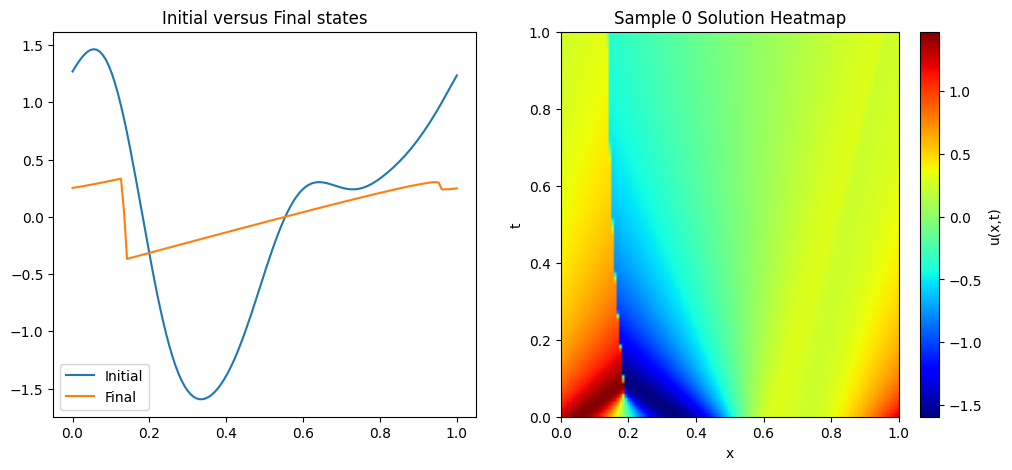

In [5]:
# --- Example Usage ---
if __name__ == "__main__":
    # Generate data
    data_dict = create_burgers_dataset(N_SAMPLES=100, Nx=128, Nt=101, X_MUL=4, T_MUL=5)
    
    # Verification Plot
    sample_idx = np.random.randint(1)
    x_grid = np.linspace(0, 1, 128)
    u_field = data_dict['y'][sample_idx]
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)    
    plt.plot(x_grid, u_field[0], label="Initial")
    plt.plot(x_grid, u_field[-1], label="Final")
    plt.title("Initial versus Final states")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.imshow(u_field, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
    plt.colorbar(label="u(x,t)")
    plt.title(f"Sample {sample_idx} Solution Heatmap")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.show()

<h2>Test the model</h2>

In [15]:
# Load the test data
import scipy.io

# Load the file
mat_data = scipy.io.loadmat('/home/tp526/Characteristics/data/test_data/burgers_truth_x100_t101_1000.mat')

# View the keys (variable names) inside the file
print(mat_data.keys())

# Access a specific variable (e.g., if you had a variable named 'my_array')
data_dict = {
    'x' : mat_data['input'],
    'y' : mat_data['output'],
    'visc' : mat_data['visc']
}

dict_keys(['__header__', '__version__', '__globals__', 'input', 'output', 'visc'])


In [5]:
def format_burgers_data(data_dict):
    """
    Reshapes the Burgers dataset into a coordinate-based format.
    
    Args:
        data_dict (dict): Dictionary with keys 'x' (N, Nx) and 'y' (N, Nt, Nx).
        
    Returns:
        np.array: A single array of shape (N_SAMPLES, Nt, Nx, 3).
                  Channel 0: u0(x) repeated over time
                  Channel 1: x coordinates
                  Channel 2: t coordinates
    """
    # 1. Extract dimensions
    # data_dict['x'] is the initial condition u0, shape (N, Nx)
    # data_dict['y'] is the solution u, shape (N, Nt, Nx)
    u0 = data_dict['x'] 
    N_samples, Nx = u0.shape
    Nt = data_dict['y'].shape[1]
    
    print(f"Dimensions detected: N={N_samples}, Nt={Nt}, Nx={Nx}")

    # 2. Create Mesh Grids (Nt, Nx)
    # Recreate the grids used in the solver
    x_1d = np.linspace(0, 1, Nx, endpoint=False)
    t_1d = np.linspace(0, 1, Nt)
    
    # Create 2D grids. indexing='ij' ensures output is (Nt, Nx)
    # T_grid varies along axis 0, X_grid varies along axis 1
    T_grid, X_grid = np.meshgrid(t_1d, x_1d, indexing='ij')
    
    # 3. Broadcast/Repeat Arrays to shape (N, Nt, Nx)
    
    # Channel 0: u0 (Initial Condition)
    # Input: (N, Nx) -> Expand to (N, 1, Nx) -> Tile to (N, Nt, Nx)
    u0_expanded = np.tile(u0[:, None, :], (1, Nt, 1))
    
    # Channel 1: X Grid
    # Input: (Nt, Nx) -> Expand to (1, Nt, Nx) -> Broadcast to (N, Nt, Nx)
    X_expanded = np.tile(X_grid[None, :, :], (N_samples, 1, 1))
    
    # Channel 2: T Grid
    # Input: (Nt, Nx) -> Expand to (1, Nt, Nx) -> Broadcast to (N, Nt, Nx)
    T_expanded = np.tile(T_grid[None, :, :], (N_samples, 1, 1))
    
    # 4. Stack along the last axis
    # Result shape: (N, Nt, Nx, 3, 1)
    formatted_data = np.stack([u0_expanded, X_expanded, T_expanded], axis=-1)
    
    return formatted_data

In [16]:
formatted_inputs = format_burgers_data(data_dict)
formatted_inputs.shape

Dimensions detected: N=1000, Nt=101, Nx=100


(1000, 101, 100, 3)

In [17]:
#model.eval()

N_CASE = formatted_inputs.shape[0]

l2_errors = np.zeros(N_CASE)
l1_errors = np.zeros(N_CASE)

with torch.no_grad():
    for k in range(N_CASE):
        x = torch.tensor(formatted_inputs[k:k+1], dtype=torch.float32).to(device)
        y = torch.tensor(data_dict["y"][k:k+1], dtype=torch.float32).to(device)

        out = model(x).reshape(y.shape)

        # Relative L2
        l2 = torch.norm(out - y, p=2) / torch.norm(y, p=2)
        l2_errors[k] = l2.item()

        # Relative L1
        l1 = torch.norm(out - y, p=1) / torch.norm(y, p=1)
        l1_errors[k] = l1.item()

        if (k+1) % 100 == 0:
            print(f'Sample {k+1}/{N_CASE}: ')
            print(f'    Mean L2-relative-error: {np.mean(l2_errors[:(k+1)]):.6e}')
            print(f'    Mean L1-relative-error: {np.mean(l1_errors[:(k+1)]):.6e}')
            print("-" * 50 + "\n")

print(f"Mean L2-relative-error over 1000 tests: {np.mean(l2_errors):.6e}")
print(f"Mean L1-relative-error over 1000 tests: {np.mean(l1_errors):.6e}")
print(f"L2 std: {np.std(l2_errors):.6e}")
print(f"L1 std: {np.std(l1_errors):.6e}")


Sample 100/1000: 
    Mean L2-relative-error: 1.136340e-01
    Mean L1-relative-error: 4.165481e-02
--------------------------------------------------

Sample 200/1000: 
    Mean L2-relative-error: 1.117192e-01
    Mean L1-relative-error: 3.986567e-02
--------------------------------------------------

Sample 300/1000: 
    Mean L2-relative-error: 1.115548e-01
    Mean L1-relative-error: 4.065235e-02
--------------------------------------------------

Sample 400/1000: 
    Mean L2-relative-error: 1.112236e-01
    Mean L1-relative-error: 4.049552e-02
--------------------------------------------------

Sample 500/1000: 
    Mean L2-relative-error: 1.117606e-01
    Mean L1-relative-error: 4.064021e-02
--------------------------------------------------

Sample 600/1000: 
    Mean L2-relative-error: 1.116855e-01
    Mean L1-relative-error: 4.039927e-02
--------------------------------------------------

Sample 700/1000: 
    Mean L2-relative-error: 1.121387e-01
    Mean L1-relative-error: 4

In [21]:
np.min(l1_errors)

np.float64(0.013536940328776836)

In [ ]:
#

Input shape:  torch.Size([1, 101, 128, 3])
Output shape:  torch.Size([1, 101, 128])


==Relative L1 error mean:  0.037682==

Ground Truth


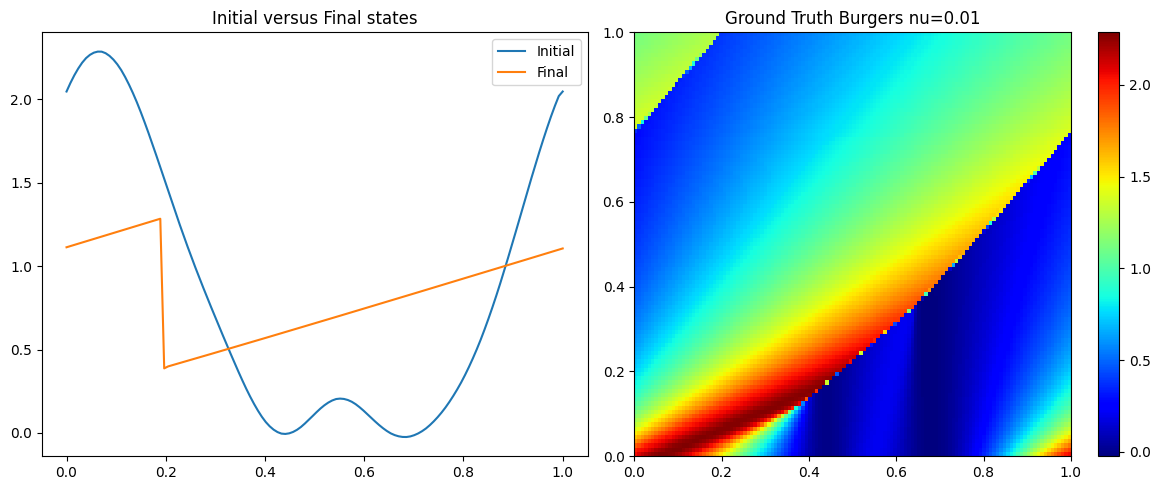

Prediction


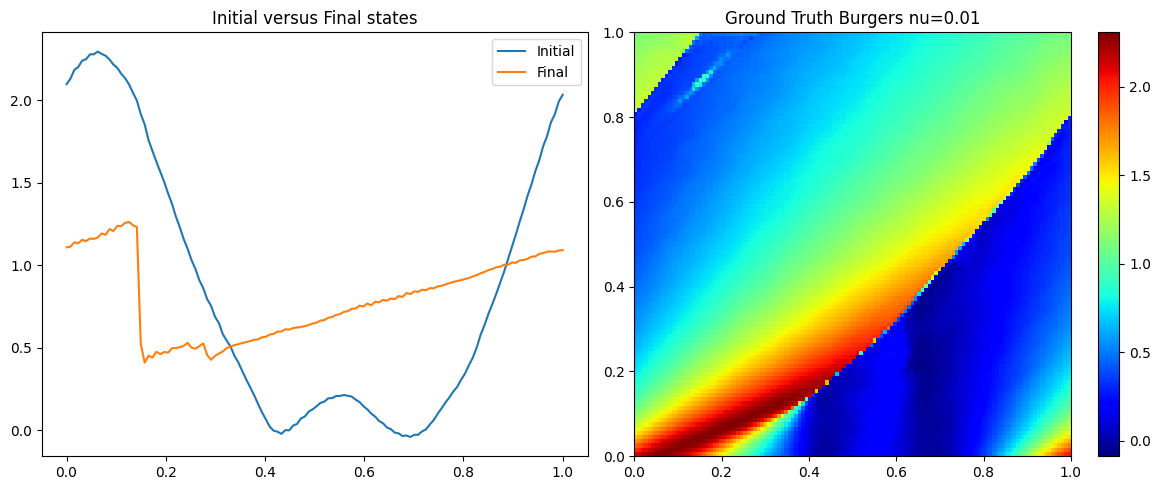

In [14]:
import matplotlib.pyplot as plt

k = np.random.randint(1000)

x, y = torch.tensor(formatted_inputs[k:k+1], dtype=torch.float32).to(device), torch.tensor(data_dict["y"][k:k+1], dtype=torch.float32).to(device)

print("Input shape: ", x.shape)
print("Output shape: ", y.shape)
print("\n")

out = model(x).reshape(y.shape)

data_loss = torch.norm(out - y, p=1) / torch.norm(y, p=1)

print(f'==Relative L1 error mean: {data_loss.item() : .6f}==\n')

# Plot
print("Ground Truth")
truth = y[0].detach().cpu().numpy()
x_grid = np.linspace(0, 1, truth.shape[1])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_grid, truth[0], label="Initial")
plt.plot(x_grid, truth[-1], label="Final")
plt.title("Initial versus Final states")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(truth, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
plt.title("Ground Truth Burgers nu=0.01")
plt.colorbar()

plt.tight_layout()
plt.show()

print("Prediction")
pred = out[0].detach().cpu().numpy()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_grid, pred[0], label="Initial")
plt.plot(x_grid, pred[-1], label="Final")
plt.title("Initial versus Final states")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(pred, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
plt.title("Ground Truth Burgers nu=0.01")
plt.colorbar()

plt.tight_layout()
plt.show()



In [31]:
dataset = BurgersLoader("/home/tp526/neuraloperator/data/burgers_pino.mat",
                            nx=128, nt=100,
                            sub=1, sub_t=1, new=True)
train_loader = dataset.make_loader(n_sample=10,
                                    batch_size=1,
                                    start=0)

/home/tp526/.conda/envs/dde/lib/python3.11/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [32]:
for batch in train_loader:
    x, y = batch
    print(x.shape)

torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])


In [38]:
import scipy

# We map 'x' -> 'input' and 'y' -> 'output'
mat_data = {
    'input': data_dict['x'],
    'output': data_dict['y'],
    'visc': data_dict['visc']
}

# 3. Save to .mat file
# do_compression=True helps if the arrays are large
scipy.io.savemat('/home/tp526/neuraloperator/data/test_data/burgers_truth_x128_t101_1000.mat', mat_data, do_compression=True)

print("Saved to /home/tp526/neuraloperator/data/test_data/burgers_truth_x128_t101_1000.mat")

Saved to /home/tp526/neuraloperator/data/test_data/burgers_truth_x128_t101_1000.mat


In [19]:
print("-" * 100)
print("\nNumber of trainable parameters: ", sum(p.numel() for p in model.parameters()))
print("\n" + "-" * 100)

----------------------------------------------------------------------------------------------------

Number of trainable parameters:  4383489

----------------------------------------------------------------------------------------------------


<h2>Relatve Errors on a snapshot t = 0.65</h2>

In [18]:
#model.eval()

N_CASE = formatted_inputs.shape[0]

l2_errors_snapshot = np.zeros(N_CASE)
l1_errors_snapshot = np.zeros(N_CASE)

with torch.no_grad():
    for k in range(N_CASE):
        x = torch.tensor(formatted_inputs[k:k+1], dtype=torch.float32).to(device)
        y = torch.tensor(data_dict["y"][k:k+1], dtype=torch.float32).to(device)

        out = model(x).reshape(y.shape)

        y = y[:, 65]
        out = out[:, 65]

        # Relative L2
        l2 = torch.norm(out - y, p=2) / torch.norm(y, p=2)
        l2_errors_snapshot[k] = l2.item()

        # Relative L1
        l1 = torch.norm(out - y, p=1) / torch.norm(y, p=1)
        l1_errors_snapshot[k] = l1.item()

        if (k+1) % 100 == 0:
            print(f'Sample {k+1}/{N_CASE}: ')
            print(f'    Mean L2-relative-error: {np.mean(l2_errors_snapshot[:(k+1)]):.6e}')
            print(f'    Mean L1-relative-error: {np.mean(l1_errors_snapshot[:(k+1)]):.6e}')
            print("-" * 50 + "\n")

print(f"Mean L2-relative-error over 1000 tests: {np.mean(l2_errors_snapshot):.6e}")
print(f"Mean L1-relative-error over 1000 tests: {np.mean(l1_errors_snapshot):.6e}")
print(f"L2 std: {np.std(l2_errors_snapshot):.6e}")
print(f"L1 std: {np.std(l1_errors_snapshot):.6e}")


Sample 100/1000: 
    Mean L2-relative-error: 1.402130e-01
    Mean L1-relative-error: 4.991546e-02
--------------------------------------------------

Sample 200/1000: 
    Mean L2-relative-error: 1.331841e-01
    Mean L1-relative-error: 4.547410e-02
--------------------------------------------------

Sample 300/1000: 
    Mean L2-relative-error: 1.328369e-01
    Mean L1-relative-error: 4.654937e-02
--------------------------------------------------

Sample 400/1000: 
    Mean L2-relative-error: 1.330421e-01
    Mean L1-relative-error: 4.663740e-02
--------------------------------------------------

Sample 500/1000: 
    Mean L2-relative-error: 1.333811e-01
    Mean L1-relative-error: 4.617421e-02
--------------------------------------------------

Sample 600/1000: 
    Mean L2-relative-error: 1.343131e-01
    Mean L1-relative-error: 4.652301e-02
--------------------------------------------------

Sample 700/1000: 
    Mean L2-relative-error: 1.356112e-01
    Mean L1-relative-error: 4

In [28]:
data_dict["y"].shape

(1000, 101, 128)